In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import missingno as msno
import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')



['house-prices-advanced-regression-techniques']


In [3]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
#train.head()

In [4]:
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
#test.head()

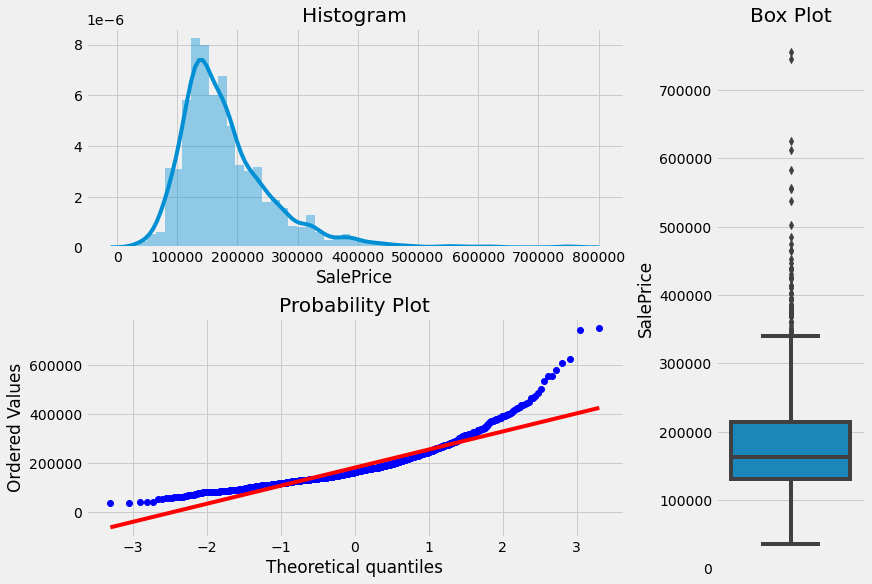

In [5]:
def plotting_3_chart(df, feature):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(train, 'SalePrice')

In [6]:
#skewness and kurtosis
print("Skewness: " + str(train['SalePrice'].skew()))
print("Kurtosis: " + str(train['SalePrice'].kurt()))

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [7]:
#Getting the Correlation of all the features with target variable.
(train.corr()**2)['SalePrice'].sort_values(ascending=False)[1:]

OverallQual      0.625652
GrLivArea        0.502149
GarageCars       0.410124
GarageArea       0.388667
TotalBsmtSF      0.376481
1stFlrSF         0.367057
FullBath         0.314344
TotRmsAbvGrd     0.284860
YearBuilt        0.273422
YearRemodAdd     0.257151
GarageYrBlt      0.236548
MasVnrArea       0.228000
Fireplaces       0.218023
BsmtFinSF1       0.149320
LotFrontage      0.123763
WoodDeckSF       0.105244
2ndFlrSF         0.101974
OpenPorchSF      0.099765
HalfBath         0.080717
LotArea          0.069613
BsmtFullBath     0.051585
BsmtUnfSF        0.046001
BedroomAbvGr     0.028296
KitchenAbvGr     0.018471
EnclosedPorch    0.016532
ScreenPorch      0.012420
PoolArea         0.008538
MSSubClass       0.007104
OverallCond      0.006062
MoSold           0.002156
3SsnPorch        0.001988
YrSold           0.000837
LowQualFinSF     0.000656
Id               0.000480
MiscVal          0.000449
BsmtHalfBath     0.000284
BsmtFinSF2       0.000129
Name: SalePrice, dtype: float64

In [8]:
#Using Scatter Plot
def customized_scatter(y,x):
    style.use('fivethirtyeight')
    plt.subplots(figsize=(12,8))
    sns.scatterplot(y=y,x=x)

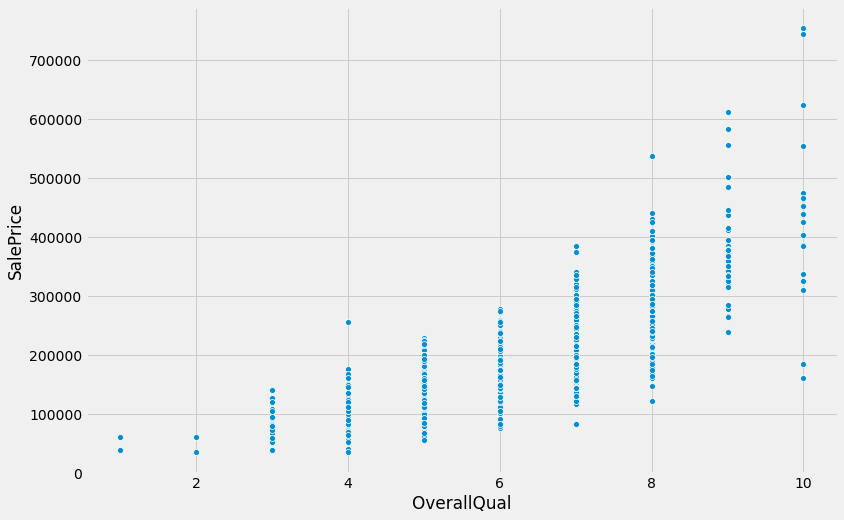

In [9]:
customized_scatter(train.SalePrice,train.OverallQual)

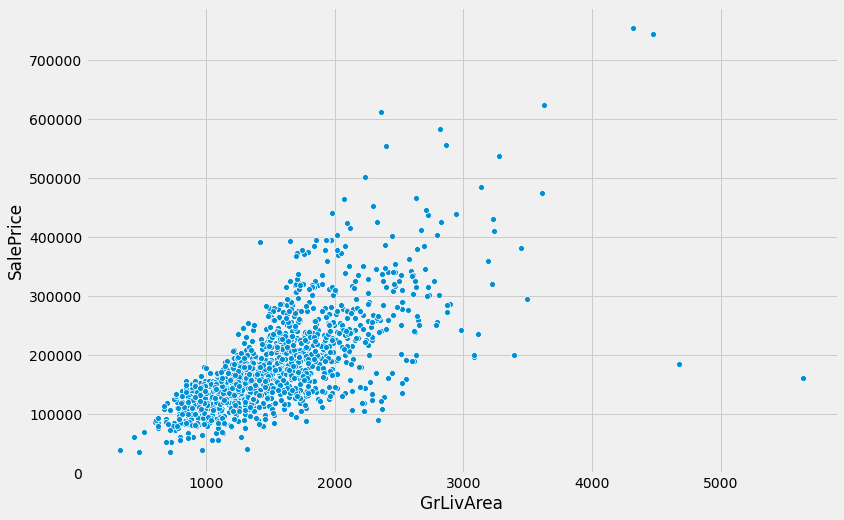

In [10]:
customized_scatter(train.SalePrice,train.GrLivArea)

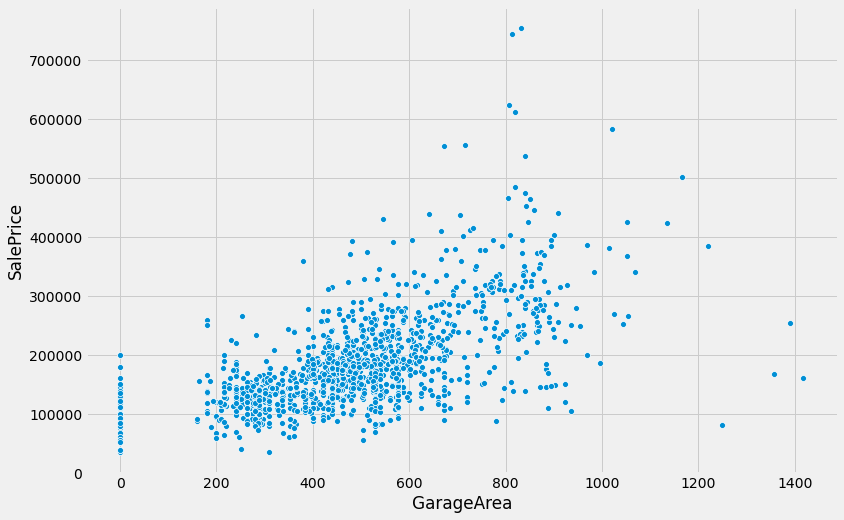

In [11]:
customized_scatter(train.SalePrice,train.GarageArea)

In [12]:
train = train[train.GrLivArea < 4500]
train.reset_index(drop = True, inplace = True)

## save a copy of this dataset so that any changes later on can be compared side by side.
previous_train = train.copy()

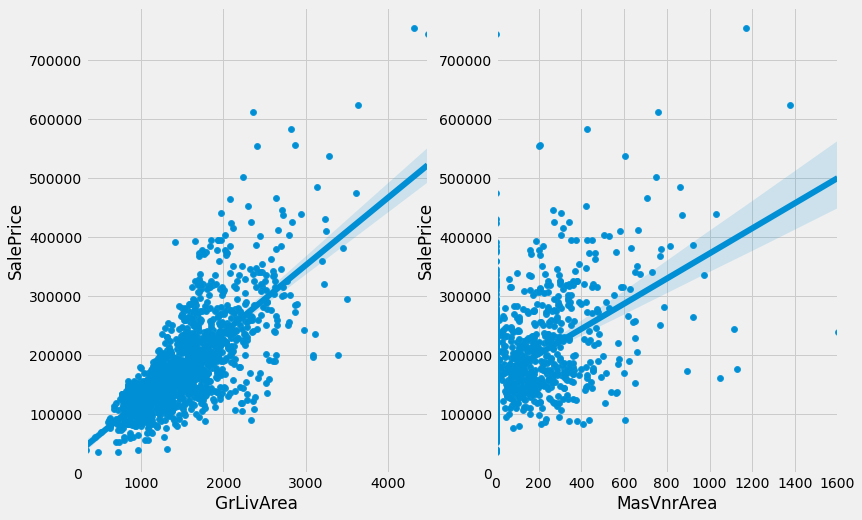

In [13]:
fig,(ax1,ax2)=plt.subplots(figsize=(12,8),ncols=2,sharey=False)
sns.scatterplot(x=train.GrLivArea,y=train.SalePrice,ax=ax1)
sns.regplot(x=train.GrLivArea,y=train.SalePrice,ax=ax1)
sns.scatterplot(x=train.MasVnrArea,y=train.SalePrice,ax=ax2)
sns.regplot(x=train.MasVnrArea,y=train.SalePrice,ax=ax2)

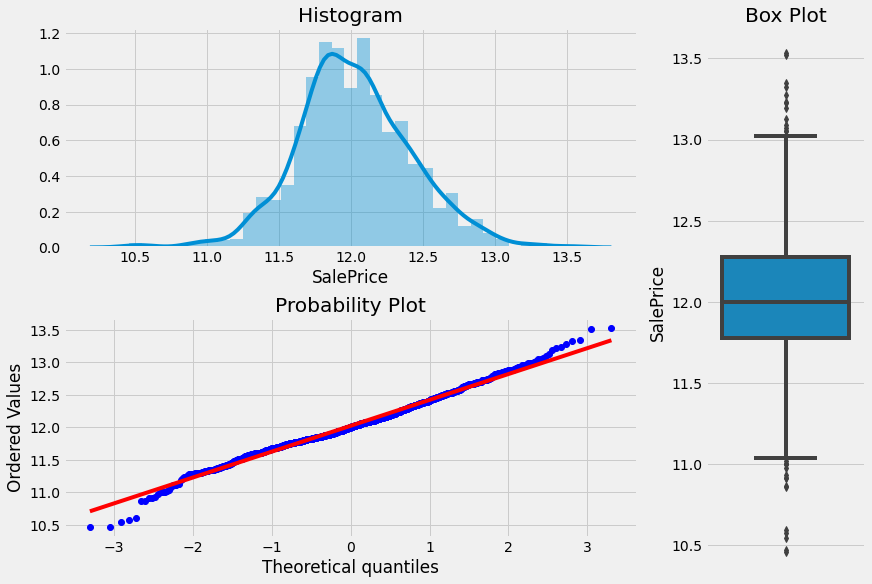

In [14]:
train["SalePrice"] = np.log1p(train["SalePrice"])

## Plotting the newly transformed response variable
plotting_3_chart(train, 'SalePrice')

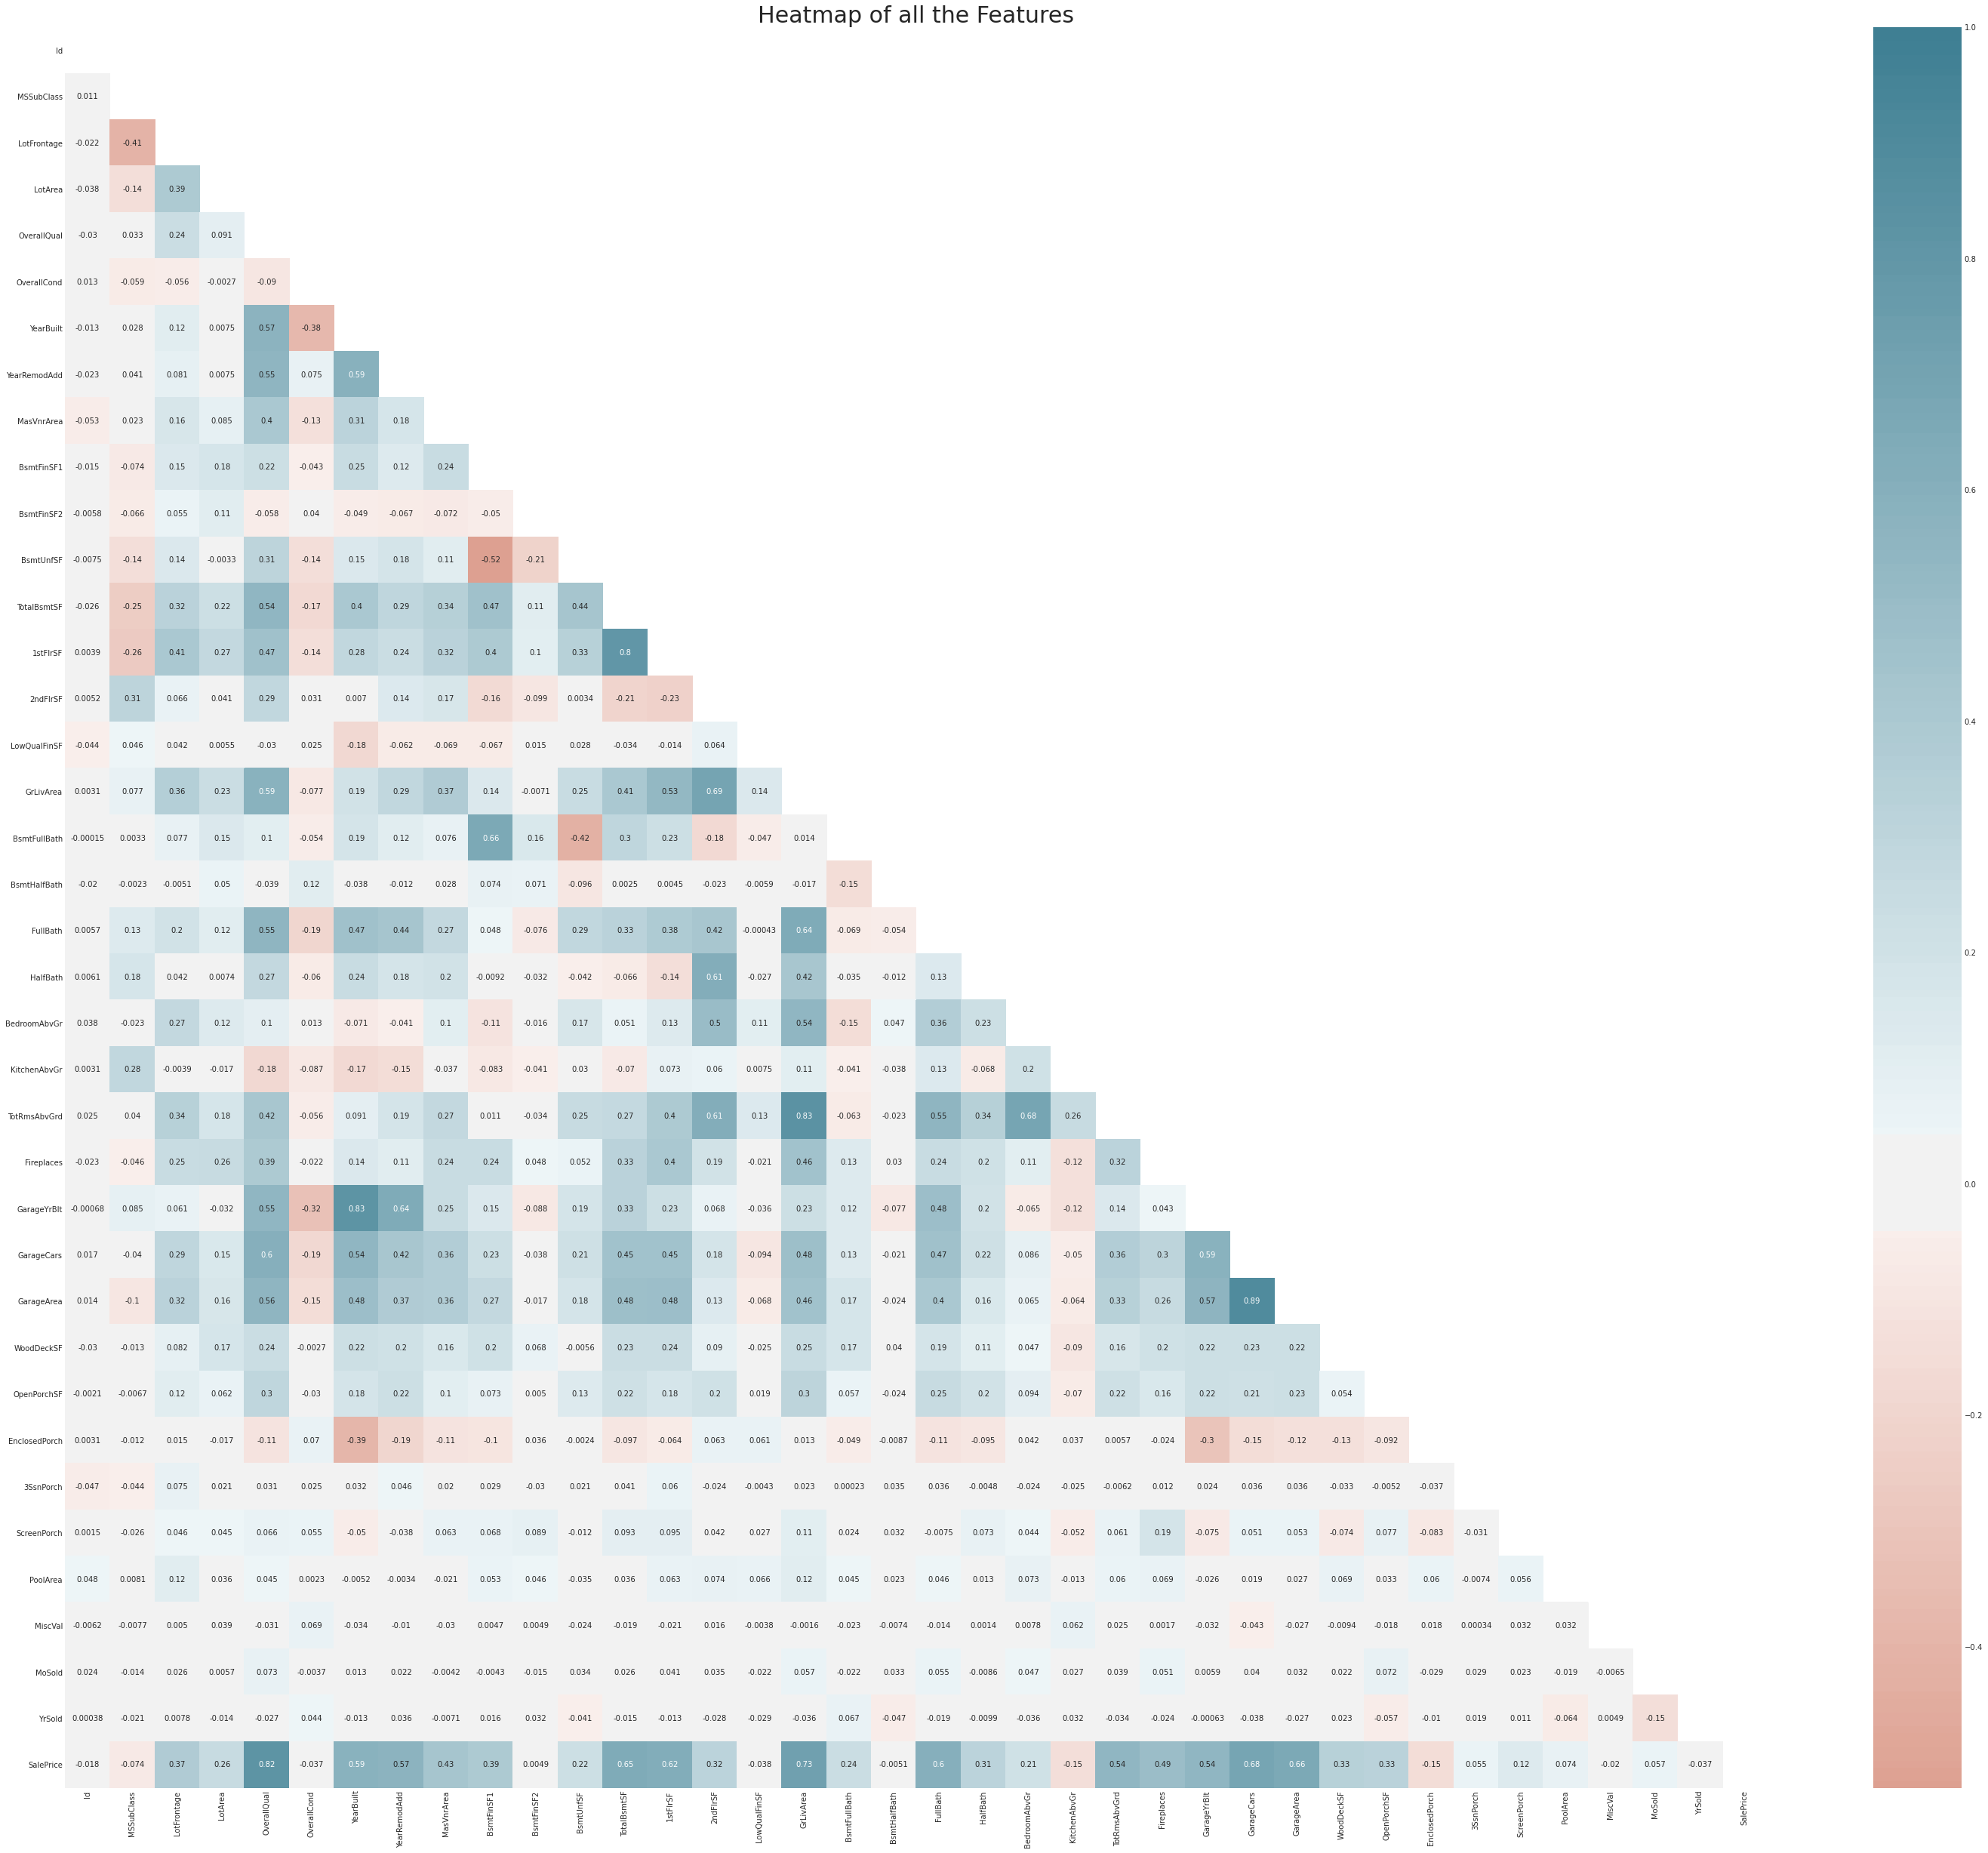

In [15]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (45,40))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(train.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
## Give title. 
plt.title("Heatmap of all the Features", fontsize = 30);

In [16]:
## Dropping the "Id" from train and test set. 
# train.drop(columns=['Id'],axis=1, inplace=True)

train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)

## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()


In [17]:
## Combining train and test datasets together so that we can do all the work at once. 
all_data = pd.concat((train, test)).reset_index(drop = True)
## Dropping the target variable. 
all_data.drop(['SalePrice'], axis = 1, inplace = True)

In [18]:
## Some missing values are intentionally left blank, for example: In the Alley feature 
## there are blank values meaning that there are no alley's in that specific house. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [19]:
## In the following features the null values are there for a purpose, so we replace them with "0"
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [20]:
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.mean()))

In [21]:
## Zoning class are given in numerical; therefore converted to categorical variables. 
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

In [22]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr") 


In [23]:
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(all_data)

,Total,Percent


In [24]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_feats

MiscVal          21.939672
PoolArea         17.688664
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
WoodDeckSF        1.844792
1stFlrSF          1.257286
GrLivArea         1.068750
LotFrontage       1.058803
BsmtFinSF1        0.980645
BsmtUnfSF         0.919688
2ndFlrSF          0.861556
TotRmsAbvGrd      0.749232
Fireplaces        0.725278
HalfBath          0.696666
TotalBsmtSF       0.671751
BsmtFullBath      0.622415
OverallCond       0.569314
BedroomAbvGr      0.326568
GarageArea        0.216857
OverallQual       0.189591
FullBath          0.165514
GarageCars       -0.219297
YearRemodAdd     -0.450134
YearBuilt        -0.599194
GarageYrBlt      -3.904632
dtype: float64

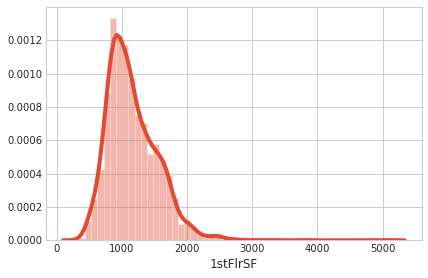

In [25]:
sns.distplot(all_data['1stFlrSF'])

In [26]:
#Fixing Skewed features using boxcos transformation
def fixing_skewness(df):
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    #Getting all the data that are not of object
    numeric_feats=df.dtypes[df.dtypes!='object'].index
    skewed_feats=df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew=skewed_feats[abs(skewed_feats)>0.5]
    skewed_features=high_skew.index
    for feat in skewed_features:
        df[feat]=boxcox1p(df[feat],boxcox_normmax(df[feat]+1))
fixing_skewness(all_data)

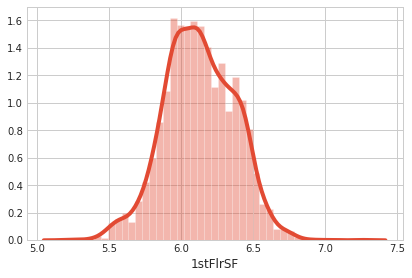

In [27]:
sns.distplot(all_data['1stFlrSF'])

**Creating New Features**

In [28]:
all_data['TotalSF']=(all_data['TotalBsmtSF']
                    +all_data['1stFlrSF']
                    +all_data['2ndFlrSF'])
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']
all_data['Total_sqr_footage']=(all_data['BsmtFinSF1']
                              +all_data['BsmtFinSF2']
                              +all_data['1stFlrSF']
                              +all_data['2ndFlrSF']
                              )
all_data['Total_Bathrooms']=(all_data['FullBath']
                             +(all_data['HalfBath']*0.5)
                             +all_data['BsmtFullBath']
                             +(all_data['BsmtHalfBath']*0.5)
                            )
all_data['Total_porch_sf']=(all_data['OpenPorchSF'] 
                              + all_data['3SsnPorch'] 
                              + all_data['EnclosedPorch'] 
                              + all_data['ScreenPorch'] 
                              + all_data['WoodDeckSF']
                             )

In [29]:
all_data['haspool']=all_data['PoolArea'].apply(lambda x:1 if x>0 else 0)
all_data['has2ndfloor']=all_data['2ndFlrSF'].apply(lambda x:1 if x>0 else 0)
all_data['hasgarage']=all_data['GarageArea'].apply(lambda x:1 if x>0 else 0)
all_data['hasbsmt']=all_data['TotalBsmtSF'].apply(lambda x:1 if x>0 else 0)
all_data['hasfireplace']=all_data['Fireplaces'].apply(lambda x:1 if x>0 else 0)

In [30]:
all_data.shape

(2917, 89)

In [31]:
#deleting Features
all_data=all_data.drop(['Utilities','Street','PoolQC'],axis=1)

**Creating Dummy Variables**

In [32]:
final_features=pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2917, 333)

In [33]:
X=final_features.iloc[:len(y),:]
X_sub=final_features.iloc[len(y):,:]

In [34]:
outliers=[30,88,462,631,1322]
X=X.drop(X.index[outliers])
y=y.drop(y.index[outliers])

In [35]:
counts=X.BsmtUnfSF.value_counts()

In [36]:
counts.iloc[0]

117

In [37]:
for col in X.columns:
    counts=X[col].value_counts()
    print(counts)

17.840338    142
19.692957     70
21.443063     69
15.860627     56
20.579606     52
            ... 
50.265670      1
30.655041      1
13.491610      1
25.626054      1
12.088318      1
Name: LotFrontage, Length: 132, dtype: int64
13.480169    25
14.117918    24
13.084300    17
13.819883    14
13.973433    14
             ..
11.326490     1
13.731662     1
12.010824     1
14.269176     1
14.651202     1
Name: LotArea, Length: 1068, dtype: int64
5     396
6     374
7     318
8     167
4     115
9      43
3      19
10     16
2       3
1       2
Name: OverallQual, dtype: int64
3.991517    816
4.679501    252
5.348041    205
6.000033     72
3.280100     56
2.539439     25
6.637669     22
1.760360      4
0.926401      1
Name: OverallCond, dtype: int64
2.803724e+51    66
2.781536e+51    64
2.759512e+51    54
2.826078e+51    48
2.737652e+51    45
                ..
1.230940e+51     1
9.317781e+50     1
1.315942e+51     1
2.894147e+51     1
1.160813e+51     1
Name: YearBuilt, Length: 112, dty

In [38]:
def overfit_reducer(df):
    overfit=[]
    for i in df.columns:
        counts=df[i].value_counts()
        zeros=counts.iloc[0]
        if zeros/len(df)*100>99.94:
            overfit.append(i)
    overfit=list(overfit)
    return overfit
overfitted_features=overfit_reducer(X)
X=X.drop(overfitted_features,axis=1)
X_sub=X_sub.drop(overfitted_features,axis=1)

In [39]:
X.shape,y.shape,X_sub.shape

((1453, 332), (1453,), (1459, 332))

**Splitting the Data for validation**

In [40]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=0)

In [41]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((973, 332), (973,), (480, 332), (480,))

Using Basic Linear Model with CrossValidation

In [42]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold
lin_reg=LinearRegression()
cv=KFold(shuffle=True,random_state=2,n_splits=10)
scores=cross_val_score(lin_reg,X,y,cv=cv,scoring='neg_mean_absolute_error')

In [43]:
print ('%.8f'%scores.mean())

-0.24789990


**Using Ridge Regularization Model**

In [44]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_squared_error

#Assinging different sets of alpha values to explore which could fit best for the mode
alpha_ridge=[-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_rss={}
temp_mse={}
for i in alpha_ridge:
    ridge=Ridge(alpha=i,normalize=True)
    ridge.fit(X_train,y_train)
    y_pred=ridge.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    rss=sum((y_pred-y_test)**2)
    temp_mse[i]=mse
    temp_rss[i]=rss

In [45]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.01: 0.012058094370480164
0.001: 0.012361806603927696
0.5: 0.012398339973189202
0.0001: 0.012454841287233696
1e-05: 0.012608710730136152
1e-08: 0.0126893901923484
1e-10: 0.0126894976287673
1e-15: 0.01272654915332125
1: 0.013828461560547015
1.5: 0.015292912795237435
2: 0.01675982661618646
3: 0.01967921651436235
4: 0.02256515573645601
5: 0.025406035244404514
10: 0.03869750095086974
20: 0.0601695168249373
30: 0.07597213350938208
40: 0.08783870538314079
-1: 22.58422641521672
-3: 37.77842237301035
-2: 1127.9917645487503


In [46]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))


0.01: 5.7878852978304804
0.001: 5.933667169885292
0.5: 5.9512031871308135
0.0001: 5.978323817872172
1e-05: 6.0521811504653495
1e-08: 6.090907292327233
1e-10: 6.090958861808304
1e-15: 6.108743593594201
1: 6.637661549062566
1.5: 7.34059814171397
2: 8.044716775769503
3: 9.446023926893936
4: 10.831274753498889
5: 12.194896917314168
10: 18.574800456417492
20: 28.881368075969917
30: 36.46662408450335
40: 42.16257858390757
-1: 10840.428679304025
-3: 18133.64273904496
-2: 541436.0469834004


In [47]:
from sklearn.linear_model import Lasso
temp_rss={}
temp_mse={}
for i in alpha_ridge:
    lasso_reg=Lasso(alpha=i,normalize=True)
    lasso_reg.fit(X_train,y_train)
    y_pred=lasso_reg.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    rss=sum((y_pred-y_test)**2)
    temp_rss[i]=rss
    temp_mse[i]=mse

In [48]:
for key,value in sorted(temp_mse.items(),key=lambda item:item[1]):
    print("%s: %s"%(key,value))

0.0001: 0.010061310715979712
1e-05: 0.011553827909592203
1e-08: 0.012457467870656404
1e-10: 0.012462691957255533
1e-15: 0.012462746158828223
0.001: 0.018344141618527716
0.01: 0.15998234085337285
0.5: 0.16529633945001213
1: 0.16529633945001213
1.5: 0.16529633945001213
2: 0.16529633945001213
3: 0.16529633945001213
4: 0.16529633945001213
5: 0.16529633945001213
10: 0.16529633945001213
20: 0.16529633945001213
30: 0.16529633945001213
40: 0.16529633945001213
-1: 13593671878.537489
-2: 54374687295.579346
-3: 122343046250.09076


In [49]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))


0.0001: 4.829429143670259
1e-05: 5.545837396604263
1e-08: 5.979584577915073
1e-10: 5.982092139482658
1e-15: 5.982118156237546
0.001: 8.8051879768933
0.01: 76.79152360961895
0.5: 79.34224293600582
1: 79.34224293600582
1.5: 79.34224293600582
2: 79.34224293600582
3: 79.34224293600582
4: 79.34224293600582
5: 79.34224293600582
10: 79.34224293600582
20: 79.34224293600582
30: 79.34224293600582
40: 79.34224293600582
-1: 6524962501697.985
-2: 26099849901878.055
-3: 58724662200043.56


In [50]:
from sklearn.linear_model import ElasticNet
temp_rss={}
temp_mse={}
for i in alpha_ridge:
    Elastic_reg=ElasticNet(alpha=i,normalize=True)
    Elastic_reg.fit(X_train,y_train)
    y_pred=Elastic_reg.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    rss=sum((y_pred-y_test)**2)
    temp_mse[i]=mse
    temp_rss[i]=rss

In [51]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 0.010410659773781465
1e-05: 0.011786338823858473
1e-08: 0.012459291819061219
1e-10: 0.012462710337138309
1e-15: 0.012462746159012161
0.001: 0.014970896538089551
0.01: 0.10870286591783197
0.5: 0.16529633945001213
1: 0.16529633945001213
1.5: 0.16529633945001213
2: 0.16529633945001213
3: 0.16529633945001213
4: 0.16529633945001213
5: 0.16529633945001213
10: 0.16529633945001213
20: 0.16529633945001213
30: 0.16529633945001213
40: 0.16529633945001213
-3: 5.38882573851602
-2: 5.470945121453229
-1: 5.729175716122139


In [52]:
for key, value in sorted(temp_rss.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

0.0001: 4.9971166914151075
1e-05: 5.6574426354520675
1e-08: 5.980460073149386
1e-10: 5.982100961826388
1e-15: 5.98211815632584
0.001: 7.186030338282991
0.01: 52.1773756405593
0.5: 79.34224293600582
1: 79.34224293600582
1.5: 79.34224293600582
2: 79.34224293600582
3: 79.34224293600582
4: 79.34224293600582
5: 79.34224293600582
10: 79.34224293600582
20: 79.34224293600582
30: 79.34224293600582
40: 79.34224293600582
-3: 2586.6363544876885
-2: 2626.053658297549
-1: 2750.0043437386257


# Fitting Model Advanced Approach

In [53]:
kfolds=KFold(n_splits=10,shuffle=True,random_state=42)
def rmsle(y,y_pred):
    return np.sqrt(mean_squared_error(y,y_pred))
def cv_rmse(model,X=X):
    rmse=np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=kfolds))
    return (rmse)

In [54]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [55]:
ridge=make_pipeline(RobustScaler(),RidgeCV(alphas=alphas_alt,cv=kfolds))
lasso=make_pipeline(RobustScaler(),LassoCV(max_iter=1e7,
                                           alphas=alphas2,
                                           random_state=42,
                                           cv=kfolds))
elasticnet=make_pipeline(RobustScaler(),ElasticNetCV(max_iter=1e7,alphas=e_alphas,
                                                    cv=kfolds,l1_ratio=e_l1ratio))
svr=make_pipeline(RobustScaler(),SVR(C=20,epsilon=0.008,gamma=0.003))

In [56]:
gbr=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,
                             max_features='sqrt',min_samples_leaf=15,min_samples_split=10,
                             loss='huber',random_state=42)

In [57]:
lightgbm=LGBMRegressor(objective='regression',
                      num_leaves=4,
                      learning_rate=0.01,
                      n_estimators=5000,
                      max_bin=200,
                      bagging_fraction=0.75,
                      bagging_freq=5,
                      bagging_seed=7,
                      feature_fraction=0.2,
                      feature_selection=7,
                      verbose=-1
                     )

In [58]:
xgboost=XGBRegressor(learning_rate=0.01,
                     n_estimators=3460,
                     max_depth=3,min_child_weight=0,
                     gamma=0,subsample=0.7,
                     colsample_bytree=0.7,
                     objective='reg:linear',nthread=-1,
                     scale_pos_weight=1,seed=27,
                     reg_alpha=0.00006
                    )

In [59]:
stack_gen=StackingCVRegressor(regressors=(ridge,lasso,elasticnet,xgboost,lightgbm),
                             meta_regressor=xgboost,
                             use_features_in_secondary=True)

In [60]:
score=cv_rmse(ridge)
print("Ridge: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(),)

score = cv_rmse(lasso)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Ridge: 0.1011 (0.0141)
 2020-06-18 22:47:53.463259
LASSO: 0.0997 (0.0142)
 2020-06-18 22:47:59.946020
elastic net: 0.0998 (0.0143)
 2020-06-18 22:48:34.059252
SVR: 0.1140 (0.0118)
 2020-06-18 22:48:51.926134
lightgbm: 0.1053 (0.0152)
 2020-06-18 22:49:06.399145
[22:49:06] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:42] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:42] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:19] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:19] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:50:55] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in fav

In [61]:
print('Start Fit')
print('stack_gen')
stack_gen_model=stack_gen.fit(np.array(X),np.array(y))
print('elasticnet')
elastic_model_full_data=elasticnet.fit(X,y)
print('Lasso')
lasso_model_full_data = lasso.fit(X, y)
print('Ridge') 
ridge_model_full_data = ridge.fit(X, y)
print('Svr')
svr_model_full_data = svr.fit(X, y)
# print('GradientBoosting')
# gbr_model_full_data = gbr.fit(X, y)
print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

Start Fit
stack_gen
[22:55:36] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:09] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:41] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:41] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:13] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:14] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[22:57:46] WARNING: /workspace/src/objective/regression_obj.cu:168: reg:linear is now depre

**Blending the data**

In [62]:
1.0*elastic_model_full_data.predict(X)

array([12.2253507 , 12.19481394, 12.28746198, ..., 12.45059162,
       11.84620006, 11.91614323])

In [63]:
def blend_model_predict(X):
    return ((0.1*elastic_model_full_data.predict(X))+\
        (0.05 * lasso_model_full_data.predict(X)) + \
        (0.2 * ridge_model_full_data.predict(X)) + \
        (0.1 * svr_model_full_data.predict(X)) + \
#       (0.1 * gbr_model_full_data.predict(X)) + \
        (0.15 * xgb_model_full_data.predict(X)) + \
        (0.1 * lgb_model_full_data.predict(X)) + \
        (0.3 * stack_gen_model.predict(np.array(X))))
                                                  

In [64]:
print('RMSLE score on train data:')
print(rmsle(y,blend_model_predict(X)))

RMSLE score on train data:
0.05685988514628775


In [65]:
print('Predict submission')
submission=pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:,1]=np.floor(np.expm1(blend_model_predict(X_sub)))

Predict submission


In [66]:
#print('Blend with Top Kernels submissions\n')
#sub_1 = pd.read_csv('../input/top-house-price-kernel-predictions/blending_high_scores_top_1_8th_place.csv')
#sub_2 = pd.read_csv('../input/top-house-price-kernel-predictions/house_prices_ensemble_7models.csv')
#sub_3 = pd.read_csv('../input/top-house-price-kernel-predictions/blend_and_stack_LR.csv')
#submission.iloc[:,1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) + 
#                                (0.25 * sub_1.iloc[:,1]) + 
#                                (0.25 * sub_2.iloc[:,1]) + 
#                                (0.25 * sub_3.iloc[:,1]))

In [67]:
submission.head()

,Id,SalePrice
0,1461,124463.0
1,1462,159338.0
2,1463,184535.0
3,1464,201233.0
4,1465,188529.0


In [68]:
submission.to_csv("submission.csv", index=False)